In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import csv
import seaborn as sns

COLUMNS = ['AMB', 'CH4', 'CO', 'NMHC', 'NO', 'NO2',
        'NOx', 'O3', 'PM10', 'PM2.5', 'RAINFALL', 'RH',
        'SO2', 'THC', 'WD_HR', 'WIND_DIR', 'WIND_SPEED', 'WS_HR']

# Read in training set

In [23]:
def read_trainData(filename):
    # 讀入檔案
    raw_data = pd.read_csv(filename, header=None, encoding='utf8')

    # 去除標頭和多餘直行
    row, col = raw_data.shape
    raw_data  = raw_data.iloc[1:row, 3:col]              

    # 去除多餘空格
    raw_data = raw_data.replace(r'\s+', '', regex=True)  

    # 將特殊符號替換為 0
    special_chars = ['#', '*', 'x', 'A']  # 定義需要替換的特殊符號
    raw_data.replace(special_chars, 0.0, inplace=True)

    # 轉換成numpy & 浮點數型別
    data = raw_data.values 
    data = data.astype('float')

    month_to_data = {}  ## Dictionary (key:month , value:data)                                  

    # generate month_to_data(20 days data)
    for month in range(12):
        sample = np.empty(shape = (18 , 480))
        for day in range(20):
            for hour in range(24): 
                sample[:,day * 24 + hour] = data[18 * (month * 20 + day): 18 * (month * 20 + day + 1),hour]
        month_to_data[month] = sample  

    return month_to_data

# 分析圖

In [24]:

def analysis_graph(month_to_data, top_n, threshold, method='top_n'):
    data_features = np.vstack([value.T for value in month_to_data.values()])

    df_data_features = pd.DataFrame(data_features, columns=COLUMNS)
    label = np.array(df_data_features['PM2.5'][9:])
    corr_matrix = df_data_features.corr()


    print(f"================= Feature Selection - {method} =================")
 
    # 获取与 'PM2.5' 的相关性
    pm25_corr = corr_matrix['PM2.5']   
    if method == 'top_n':
        # 排序并找出与 PM2.5 最相关的前 N 个特征
        top_n =  top_n # 设置要找出的前 N 个相关特征
        top_pm25 = pm25_corr.drop('PM2.5').sort_values(ascending=False).head(top_n)
        need_features = top_pm25 
        print(f"與 PM2.5 排名最的前 {top_n} 個特徵：")
        print(top_pm25)

    elif method == 'threshold':
        # 设置一个阈值筛选出高于该值的相关性特征
        threshold = threshold  # 设定阈值 0.3
        high_corr_features = pm25_corr[pm25_corr > threshold].drop('PM2.5').sort_values(ascending=False)
        need_features = high_corr_features 
        print(f"與 PM2.5 相關性大於 {threshold} 的特徵：")
        print(high_corr_features)

    print("================= analysis graph =================")
    f,ax = plt.subplots(figsize=(9,6))
    sns.heatmap(corr_matrix, fmt='.3f', linewidths=0.5, ax=ax, cmap='coolwarm')
    plt.show()
    
    need_features = need_features.index.tolist() 
    return need_features


In [25]:

# input_train_path = '../input_data/train.csv'
# month_to_data = read_trainData(input_train_path)
# need_features = analysis_graph(month_to_data, top_n=17, threshold=0.2, method='threshold')

# Preprocess

In [26]:

def select_features(month_to_data, need_feature_index):
    # 遍历字典并保留每个数组中的指定行
    for key, value in month_to_data.items():
        # 保留指定的行索引
        month_to_data[key] = value[need_feature_index, :]
        
    return month_to_data


In [27]:

# need_feature_index = sorted([COLUMNS.index(feature) for feature in need_features]) + [9] # add PM2.5
# month_to_data = select_features(month_to_data, need_feature_index)

# print(need_features)
# print(need_feature_index)

In [28]:
def SetDataSets(month_to_data, feature_num, PM25_index):
    x = np.empty(shape = (12 * 471 , feature_num * 9),dtype = float)
    y = np.empty(shape = (12 * 471 , 1),dtype = float)

    for month in range(12): 
        for day in range(20): 
            for hour in range(24):   
                if day == 19 and hour > 14:
                    continue  
                x[month * 471 + day * 24 + hour,:] = month_to_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1,-1) 
                y[month * 471 + day * 24 + hour,0] = month_to_data[month][PM25_index ,day * 24 + hour + 9]
    return x, y


In [29]:

# FEATURE_NUM = len(need_feature_index)
# PM25_INDEX = FEATURE_NUM - 1
# x, y = SetDataSets(month_to_data, FEATURE_NUM, PM25_INDEX)
# print(x.shape)
# print(y.shape)
# print(x[0])
# print(y)

In [30]:
def Normalization(x, mean, std):
    x = x - mean
    x = x / std
    return x    


In [31]:


# train_X, valid_X, train_Y, valid_Y = train_test_split(x, y, test_size=0.2, random_state=42)
# MEAN = np.mean(train_X, axis = 0)   #计算每个属性的均值
# STD = np.std(train_X, axis = 0)     #计算每个属性的方差

# train_X = Normalization(train_X, MEAN, STD)
# valid_X = Normalization(valid_X, MEAN, STD)

# print(train_X.shape)
# print(train_Y.shape)     
# print(valid_X.shape)
# print(valid_Y.shape)     

# Linear Regression Agrad

In [32]:
def RMSE(predict_Y, real_Y):
    N = len(predict_Y)  # 樣本數量
    loss = np.sqrt(np.sum((predict_Y - real_Y)**2) / N)
    return loss


In [33]:
# RMSE
def traininig(train_X, train_Y, valid_X, valid_Y, epochs):
    dim = train_X.shape[1]
    w = np.zeros(shape = (dim, 1))
    learning_rate = np.array([[0.1]] * dim)
    adagrad_sum = np.zeros(shape = (dim, 1))  
    epoch = epochs
    loss_history = np.zeros([epoch, 1])         # 紀錄梯度下降損失數值，觀察收斂快慢
    loss_val_history = np.zeros([epoch, 1])     # 用来紀錄驗證集變化
    min_loss_val = 0
    print("================= traininig =================")
    for T in range(epoch):
        predict_Y = train_X.dot(w)   
        rmse_loss = RMSE(predict_Y, train_Y)
        loss_history[T] = rmse_loss
        
        
        # 紀錄驗證集變化
        pre = np.dot(valid_X, w)
        loss_val_history[T] = RMSE(pre, valid_Y)     
    
        if T % 500 == 0:
            print(f"T={T}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[T][0]:.4f}")
        if T == 0 or min_loss_val > loss_val_history[T][0]:
            min_loss_val = loss_val_history[T][0]
            np.save(f'weight.npy',w)   ## save weight
            
        # Compute gradient (MSE gradient)
        gradient = 2 * np.dot(np.transpose(train_X), (predict_Y-train_Y)) / len(train_Y)
        
        # Update Adagrad sum
        adagrad_sum += gradient ** 2
        Sigma = np.sqrt(adagrad_sum)
        
        # Update weights using Adagrad
        w = w - learning_rate * gradient / (Sigma + 0.0006)
    
    print(f"T={epochs-1}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[epochs-1][0]:.4f}")
    # np.save('weight.npy',w)   ## save weight
    
    return loss_history, loss_val_history

In [34]:
def graph_val_Train(epochs, loss_history, loss_val_history):
    epoch = np.arange(epochs)
    plt.plot(epoch, loss_history)
    plt.plot(epoch, loss_val_history) 
    plt.show()

In [35]:

# m, dim = train_X.shape   #获取 X_train 的行数 X_rows 和列数 X_cols
# m_val = len(valid_X)
# dim = dim + 1  #维度加 1 
# train_X = np.concatenate((np.ones([len(train_X),1]),train_X), axis = 1).astype(float)  #在X_train前面加了一列1
# valid_X = np.concatenate((np.ones([len(valid_X),1]),valid_X), axis = 1).astype(float)  #在X_val前面加了一列1
  
    
# epochs = 10000
# loss_history, loss_val_history = traininig(train_X, train_Y, valid_X, valid_Y, epochs)
# # loss_history, loss_val_history = traininig2(train_X, train_Y, valid_X, valid_Y, m_val)
# graph_val_Train(epochs, loss_history, loss_val_history)

# predict valid

In [36]:
def validation(valid_X, valid_Y):
    
    w = np.load('weight.npy')   
    valid_predict_Y = valid_X.dot(w)

    predict_rmse = RMSE(valid_predict_Y, valid_Y)
    print("================= validation =================")
    for i in range(len(valid_Y)):
        print(f"predict_Y[i], Y[i]: {valid_predict_Y[i]}, {valid_Y[i]}")
        
    print(f"predict_rmse: {predict_rmse}")
    return predict_rmse
    


In [37]:
# predict_rmse = validation(valid_X, valid_Y)
# # 4.6049422315917035 0.3 20000
# # 4.6034760721810075 0.2 20000


# Read in Testing set

In [38]:
def read_testData(filename, feautre_num, need_feature_index):
    # 讀入檔案
    raw_data = pd.read_csv(filename, header=None, encoding='utf8')

    # 去除標頭和多餘直行
    row, col = raw_data.shape
    raw_data  = raw_data.iloc[:, 2:col]              

    # 去除多餘空格
    raw_data = raw_data.replace(r'\s+', '', regex=True)  

    # 將特殊符號替換為 0
    special_chars = ['#', '*', 'x', 'A','WIND_DIR+D2070EC']  # 定義需要替換的特殊符號
    raw_data.replace(special_chars, 0.0, inplace=True)
    
    # 轉換成numpy & 浮點數型別
    data = raw_data.values 
    data = data.astype('float')

    test_row = 244
    test_x = np.empty(shape = (test_row, feautre_num * 9),dtype = float)

    for i in range(test_row):
        features_arr = data[18 * i : 18 * (i+1),:]
        clean_features = features_arr[need_feature_index, :]
        test_x[i, :] = clean_features.reshape(1, -1)


    return test_x


# predict test

In [39]:

def write_result(predict_Y):
    
    with open('../output/result.csv', "w", newline='') as f:
        w = csv.writer(f)
        title = ['index','answer']
        w.writerow(title) 
        for i in range(244):
            content = ['index_'+str(i),int(np.round(predict_Y[i][0], 0))]
            w.writerow(content) 
    
    print("write complete!")

In [40]:
def testing(input_test_path, feautre_num, need_feature_index, mean, std):
    test_X = read_testData(input_test_path, feautre_num, need_feature_index) 
    test_X = Normalization(test_X, mean, std)
    test_X = np.concatenate((np.ones(shape = (test_X.shape[0],1)),test_X),axis = 1).astype(float)
    
    print("================= testing =================")
    w = np.load('weight.npy') 
    predict_Y = test_X.dot(w)
    write_result(predict_Y)
 


In [41]:

# input_test_path = '../input_data/test.csv'    
# testing(input_test_path, FEATURE_NUM, MEAN, STD)

In [42]:
def save_diff_top_n_graph(valid_predict):
    x = np.arange(1,18)
    y = valid_predict
    plt.plot(x, y, 'ro--', linewidth=2, markersize=4)
    plt.savefig('../output/diff_top_n.png')
    plt.show()

def save_diff_test_size_graph(valid_predict, train_predict, x_1):
    x = x_1
    valid_predict.reverse()
    train_predict.reverse()
    y_1 = valid_predict
    y_2 = train_predict
    plt.plot(x, y_1, 'r*--', linewidth=1, markersize=4)
    plt.plot(x, y_2, 'b*--', linewidth=1, markersize=4)
    plt.savefig('../output/diff_training_DataSets.png')
    plt.show()
    
    for i in range(len(x)):
        print(f"DataSets: {round(x[i], 2)}, valid_predict: {valid_predict[i]}, train_predict: {train_predict[i]}")


# main

================= Feature Selection - threshold =================
與 PM2.5 相關性大於 0.2 的特徵：
PM10    0.816310
CO      0.600925
NMHC    0.511133
NO2     0.499470
NOx     0.463238
THC     0.303378
SO2     0.297900
NO      0.233854
CH4     0.218112
Name: PM2.5, dtype: float64
================= analysis graph =================


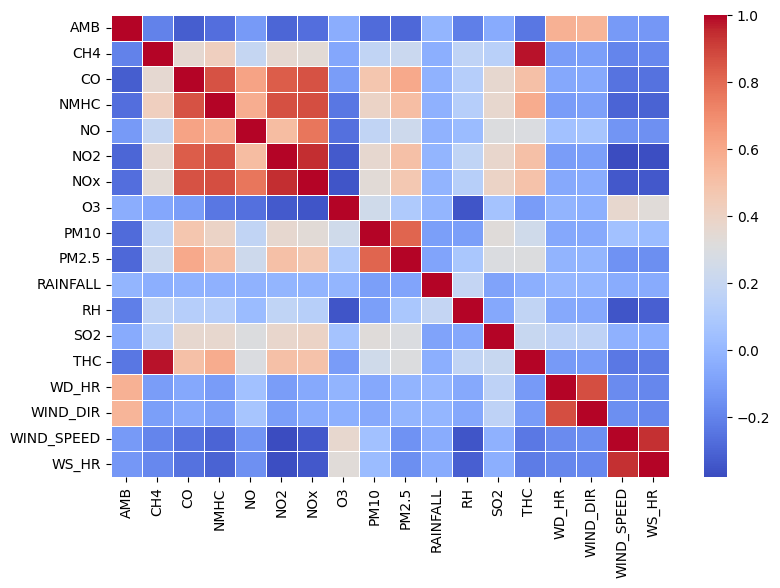

================= traininig =================
T=0, Training Loss: 16.8323, Validation Loss: 16.9257
T=500, Training Loss: 10.6422, Validation Loss: 10.6243
T=1000, Training Loss: 9.1827, Validation Loss: 9.2238
T=1500, Training Loss: 8.1852, Validation Loss: 8.2704
T=2000, Training Loss: 7.4305, Validation Loss: 7.5504
T=2500, Training Loss: 6.8338, Validation Loss: 6.9821
T=3000, Training Loss: 6.3512, Validation Loss: 6.5234
T=3500, Training Loss: 5.9559, Validation Loss: 6.1488
T=4000, Training Loss: 5.6301, Validation Loss: 5.8409
T=4500, Training Loss: 5.3605, Validation Loss: 5.5870
T=5000, Training Loss: 5.1373, Validation Loss: 5.3776
T=5500, Training Loss: 4.9524, Validation Loss: 5.2047
T=6000, Training Loss: 4.7995, Validation Loss: 5.0623
T=6500, Training Loss: 4.6731, Validation Loss: 4.9450
T=7000, Training Loss: 4.5688, Validation Loss: 4.8486
T=7500, Training Loss: 4.4830, Validation Loss: 4.7695
T=8000, Training Loss: 4.4124, Validation Loss: 4.7047
T=8500, Training Lo

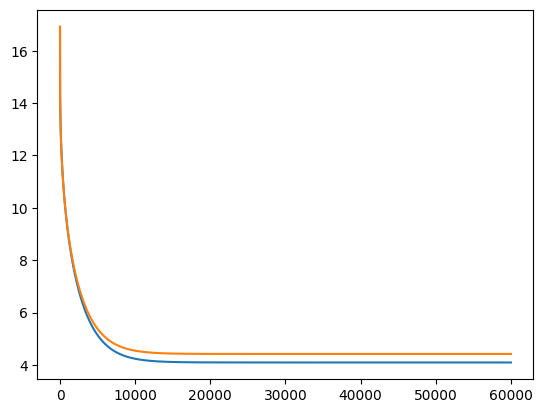

================= validation =================
predict_Y[i], Y[i]: [9.9305478], [8.]
predict_Y[i], Y[i]: [21.38010569], [21.]
predict_Y[i], Y[i]: [6.546975], [4.]
predict_Y[i], Y[i]: [9.20187459], [9.]
predict_Y[i], Y[i]: [11.02645533], [10.]
predict_Y[i], Y[i]: [27.93717273], [21.]
predict_Y[i], Y[i]: [8.05034704], [10.]
predict_Y[i], Y[i]: [8.7654885], [12.]
predict_Y[i], Y[i]: [4.69212432], [6.]
predict_Y[i], Y[i]: [23.9209942], [23.]
predict_Y[i], Y[i]: [24.4401807], [28.]
predict_Y[i], Y[i]: [4.15044976], [4.]
predict_Y[i], Y[i]: [21.59207616], [23.]
predict_Y[i], Y[i]: [12.60968919], [11.]
predict_Y[i], Y[i]: [20.34787337], [15.]
predict_Y[i], Y[i]: [16.2453321], [22.]
predict_Y[i], Y[i]: [8.85021633], [7.]
predict_Y[i], Y[i]: [20.74808575], [22.]
predict_Y[i], Y[i]: [10.50084628], [8.]
predict_Y[i], Y[i]: [21.01581994], [22.]
predict_Y[i], Y[i]: [6.89169544], [5.]
predict_Y[i], Y[i]: [10.48311885], [11.]
predict_Y[i], Y[i]: [7.61928648], [7.]
predict_Y[i], Y[i]: [6.21340766], [5

In [43]:
if __name__=='__main__':
    input_train_path = '../input_data/train.csv'
    input_test_path = '../input_data/test.csv'    
    valid_predict = []
    train_predict = []
    

    month_to_data = read_trainData(input_train_path)
    need_features = analysis_graph(month_to_data, top_n=17, threshold=0.2, method='threshold')
    
    need_feature_index = sorted([COLUMNS.index(feature) for feature in need_features]) + [9] # add PM2.5
    # need_feature_index = [0,1,2,3,4,5,6,8, 9]
    month_to_data = select_features(month_to_data, need_feature_index)
    

    FEATURE_NUM = len(need_feature_index)
    PM25_INDEX = FEATURE_NUM - 1

    x, y = SetDataSets(month_to_data, FEATURE_NUM, PM25_INDEX)    
    
    # for ratio in np.arange(0.1, 0.9, 0.01):
    ratio = 0.3
    train_X, valid_X, train_Y, valid_Y = train_test_split(x, y, test_size=ratio, random_state=42) #0.25 0.15 0.12
    MEAN = np.mean(train_X, axis = 0)   #计算每个属性的均值
    STD = np.std(train_X, axis = 0)     #计算每个属性的方差

    train_X = Normalization(train_X, MEAN, STD)
    valid_X = Normalization(valid_X, MEAN, STD)


    m, dim = train_X.shape   #获取 X_train 的行数 X_rows 和列数 X_cols
    m_val = len(valid_X)
    dim = dim + 1  #维度加 1 
    train_X = np.concatenate((np.ones([len(train_X),1]),train_X), axis = 1).astype(float)  #在train_X前面加了一列1
    valid_X = np.concatenate((np.ones([len(valid_X),1]),valid_X), axis = 1).astype(float)  #在valid_X前面加了一列1

    epochs = 60000
    loss_history, loss_val_history = traininig(train_X, train_Y, valid_X, valid_Y, epochs)
    graph_val_Train(epochs, loss_history, loss_val_history)

    predict_rmse = validation(valid_X, valid_Y)
    valid_predict.append(predict_rmse)
    
    # save_diff_test_size_graph(valid_predict, train_predict, np.arange(0.1, 0.9, 0.01))        
    testing(input_test_path, FEATURE_NUM, need_feature_index, MEAN, STD)
